In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import os
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Load Datasets
def load_data(sentiment_path, trader_path):
    try:
        sentiment_df = pd.read_csv( r"C:\Users\ACER\Downloads\fear_greed_index.csv")
        trader_df = pd.read_csv( r"C:\Users\ACER\Downloads\historical_data.csv")
        print("Sentiment Data Columns:", sentiment_df.columns)
        print("Trader Data Columns:", trader_df.columns)
        print("\nSentiment Data Sample:\n", sentiment_df.head())
        print("\nTrader Data Sample:\n", trader_df.head())
        return sentiment_df, trader_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

In [11]:
#  Preprocess Data
def preprocess_data(sentiment_df, trader_df):
    try:
        # Convert timestamps to datetime
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], format='%d-%m-%Y', errors='coerce')
        
        # Trader data: Try parsing Timestamp IST or Timestamp
        if 'Timestamp IST' in trader_df.columns:
            trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp IST'], dayfirst=True, errors='coerce')
        elif 'Timestamp' in trader_df.columns:
            trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'], dayfirst=True, errors='coerce')
        else:
            raise ValueError("No valid timestamp column found in trader data")
        
        # Drop rows with invalid timestamps
        sentiment_df = sentiment_df.dropna(subset=['date'])
        trader_df = trader_df.dropna(subset=['Timestamp'])
        
        # Extract date for merging
        trader_df['date'] = trader_df['Timestamp'].dt.date
        trader_df['date'] = pd.to_datetime(trader_df['date'], errors='coerce')
        
        # Clean data
        sentiment_df = sentiment_df.dropna(subset=['value']).drop_duplicates()
        trader_df = trader_df.dropna(subset=['Closed PnL', 'Size USD']).drop_duplicates(subset=['Transaction Hash'])
        
        # Filter for Bitcoin trades
        trader_df = trader_df[trader_df['Coin'] == 'BTC']
        
        # Feature engineering
        sentiment_df['is_extreme_fear'] = (sentiment_df['classification'] == 'Extreme Fear').astype(int)
        sentiment_df['is_extreme_greed'] = (sentiment_df['classification'] == 'Extreme Greed').astype(int)
        sentiment_df['sentiment_7d_avg'] = sentiment_df['value'].rolling(window=7, min_periods=1).mean()
        
        trader_df['profitability'] = trader_df['Closed PnL'] / trader_df['Size USD']
        trader_df['is_win'] = (trader_df['Closed PnL'] > 0).astype(int)
        
        # Merge datasets
        merged_df = pd.merge(trader_df, sentiment_df[['date', 'value', 'classification', 'is_extreme_fear', 'is_extreme_greed', 'sentiment_7d_avg']],
                             on='date', how='inner')
        
        print("\nMerged Data Sample:\n", merged_df.head())
        print("Merged Data Shape:", merged_df.shape)
        return merged_df
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return None

In [12]:
# Enhanced Visualizations
def perform_eda(merged_df, output_dir='plots'):
    if merged_df.empty:
        print("Error: Merged dataframe is empty. Cannot generate plots.")
        return
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Plot 1: Time-Series of Sentiment and Aggregate PnL
    daily_metrics = merged_df.groupby('date').agg({'value': 'mean', 'Closed PnL': 'sum'}).reset_index()
    if not daily_metrics.empty:
        fig, ax1 = plt.subplots(figsize=(12, 6))
        ax1.plot(daily_metrics['date'], daily_metrics['value'], color='blue', label='Fear & Greed Index')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Fear & Greed Index', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax2 = ax1.twinx()
        ax2.plot(daily_metrics['date'], daily_metrics['Closed PnL'], color='green', label='Total PnL')
        ax2.set_ylabel('Total PnL (USD)', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        fig.suptitle('Sentiment vs. Aggregate PnL Over Time')
        fig.legend(loc='upper right')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/timeseries_sentiment_pnl.png')
        print(f"Saved plot: {output_dir}/timeseries_sentiment_pnl.png")
        plt.show()
        plt.close()
    
    # Plot 2: Heatmap of PnL by Side and Sentiment Classification
    heatmap_data = merged_df.pivot_table(values='Closed PnL', index='Side', columns='classification', aggfunc='mean')
    if not heatmap_data.empty:
        plt.figure(figsize=(10, 6))
        sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', fmt='.2f')
        plt.title('Average PnL by Trade Side and Sentiment')
        plt.xlabel('Sentiment Classification')
        plt.ylabel('Trade Side')
        plt.savefig(f'{output_dir}/heatmap_pnl_side_sentiment.png')
        print(f"Saved plot: {output_dir}/heatmap_pnl_side_sentiment.png")
        plt.show()
        plt.close()
        
          
    # Plot 3: Top Traders' Win Rate by Sentiment
    top_traders = merged_df.groupby('Account')['Closed PnL'].sum().nlargest(5).index
    trader_sentiment = merged_df[merged_df['Account'].isin(top_traders)]
    trader_win_rates = trader_sentiment.groupby(['Account', 'classification'])['is_win'].mean().unstack()
    if not trader_win_rates.empty:
        trader_win_rates.plot(kind='bar', figsize=(12, 6), colormap='viridis')
        plt.title('Win Rate of Top 5 Traders by Sentiment')
        plt.xlabel('Trader Account')
        plt.ylabel('Win Rate')
        plt.legend(title='Sentiment')
        plt.tight_layout()
        plt.savefig(f'{output_dir}/top_traders_win_rate.png')
        print(f"Saved plot: {output_dir}/top_traders_win_rate.png")
        plt.show()
        plt.close()
    
    # Plot 4: Profitability vs. Sentiment
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=merged_df, x='value', y='profitability', hue='classification', size='Size USD', alpha=0.6)
    plt.title('Profitability vs. Fear & Greed Index')
    plt.xlabel('Fear & Greed Index (0–100)')
    plt.ylabel('Profitability (PnL / Size USD)')
    plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/profitability_vs_sentiment.png')
    print(f"Saved plot: {output_dir}/profitability_vs_sentiment.png")
    plt.show()
    plt.close()
     # Plot 5: Win Rate by Sentiment Classification
    win_rate_by_sentiment = merged_df.groupby('classification')['is_win'].mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=win_rate_by_sentiment, x='classification', y='is_win', palette='muted')
    plt.title('Win Rate by Sentiment Classification')
    plt.xlabel('Sentiment Classification')
    plt.ylabel('Win Rate')
    plt.xticks(rotation=45)
    plt.savefig(f'{output_dir}/win_rate_by_sentiment.png')
    print(f"Saved plot: {output_dir}/win_rate_by_sentiment.png")
    plt.show()
    plt.close()
    
    # Plot 6: Trade Size by Sentiment
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=merged_df, x='classification', y='Size USD', palette='pastel')
    plt.title('Trade Size (USD) by Sentiment Classification')
    plt.xlabel('Sentiment Classification')
    plt.ylabel('Trade Size (USD)')
    plt.xticks(rotation=45)
    plt.savefig(f'{output_dir}/trade_size_by_sentiment.png')
    print(f"Saved plot: {output_dir}/trade_size_by_sentiment.png")
    plt.show()
    plt.close()



In [13]:
#  Statistical Analysis
def statistical_analysis(merged_df):
    if merged_df.empty:
        print("Error: Merged dataframe is empty. Cannot perform statistical analysis.")
        return
    
    corr, p_value = pearsonr(merged_df['value'], merged_df['profitability'])
    print(f"\nCorrelation between Sentiment and Profitability: {corr:.3f} (p-value: {p_value:.3f})")
    
    X = merged_df[['value', 'Size USD', 'is_extreme_fear', 'is_extreme_greed']]
    y = merged_df['Closed PnL']
    model = LinearRegression()
    model.fit(X, y)
    print("\nRegression Coefficients:")
    for feature, coef in zip(X.columns, model.coef_):
        print(f"{feature}: {coef:.3f}")
    print(f"Intercept: {model.intercept_:.3f}")
    
    fear_trades = merged_df[merged_df['value'] < 25]
    greed_trades = merged_df[merged_df['value'] > 75]
    print(f"\nMean Profitability in Extreme Fear (value < 25): {fear_trades['profitability'].mean():.3f}")
    print(f"Mean Profitability in Extreme Greed (value > 75): {greed_trades['profitability'].mean():.3f}")


In [14]:
# Derive Insights
def derive_insights(merged_df):
    if merged_df.empty:
        print("Error: Merged dataframe is empty. Cannot derive insights.")
        return []
    
    insights = []
    fear_win_rate = merged_df[merged_df['is_extreme_fear'] == 1]['is_win'].mean()
    greed_win_rate = merged_df[merged_df['is_extreme_greed'] == 1]['is_win'].mean()
    insights.append(f"Win rate in Extreme Fear: {fear_win_rate:.3f}, Extreme Greed: {greed_win_rate:.3f}")
    
    buy_fear_pnl = merged_df[(merged_df['Side'] == 'Buy') & (merged_df['is_extreme_fear'] == 1)]['Closed PnL'].mean()
    sell_greed_pnl = merged_df[(merged_df['Side'] == 'Sell') & (merged_df['is_extreme_greed'] == 1)]['Closed PnL'].mean()
    insights.append(f"Mean PnL for Buy in Extreme Fear: {buy_fear_pnl:.2f}")
    insights.append(f"Mean PnL for Sell in Extreme Greed: {sell_greed_pnl:.2f}")
    
    insights.append("\nTrading Strategy Recommendations:")
    insights.append("- Buy during Extreme Fear (value < 25) for higher win rates.")
    insights.append("- Reduce trade size during Extreme Greed to manage risk.")
    insights.append("- Monitor 7-day sentiment average for trend confirmation.")
    
    print("\nInsights and Recommendations:")
    for insight in insights:
        print(insight)
    return insights

Sentiment Data Columns: Index(['timestamp', 'value', 'classification', 'date'], dtype='object')
Trader Data Columns: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')

Sentiment Data Sample:
     timestamp  value classification        date
0  1517463000     30           Fear  01-02-2018
1  1517549400     15   Extreme Fear  02-02-2018
2  1517635800     40           Fear  03-02-2018
3  1517722200     24   Extreme Fear  04-02-2018
4  1517808600     11   Extreme Fear  05-02-2018

Trader Data Sample:
                                       Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   

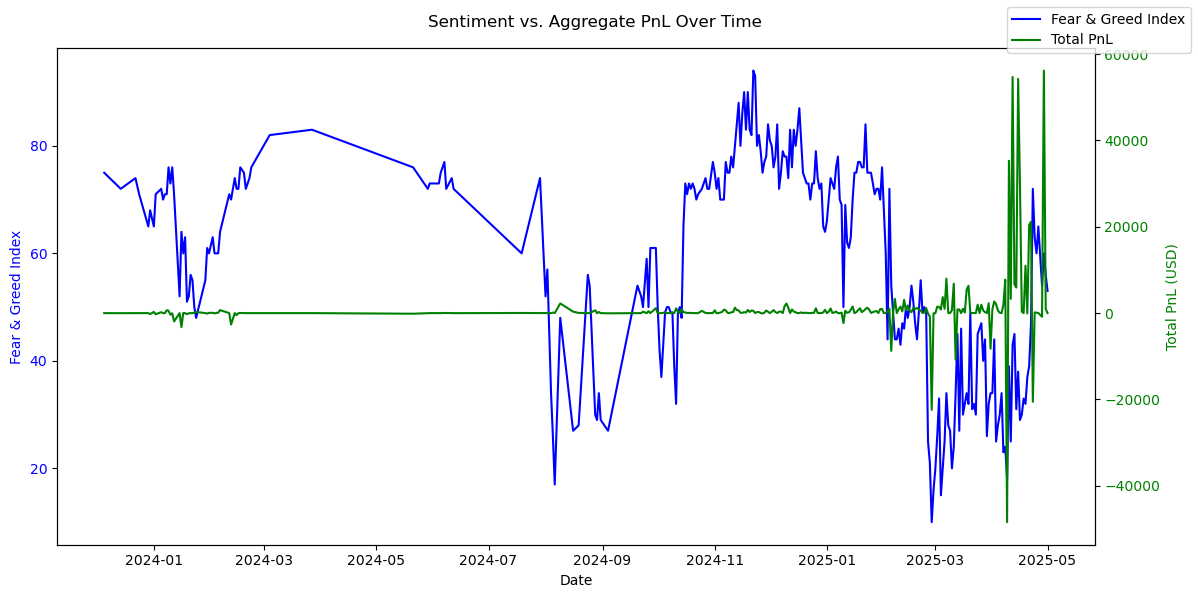

Saved plot: plots/heatmap_pnl_side_sentiment.png


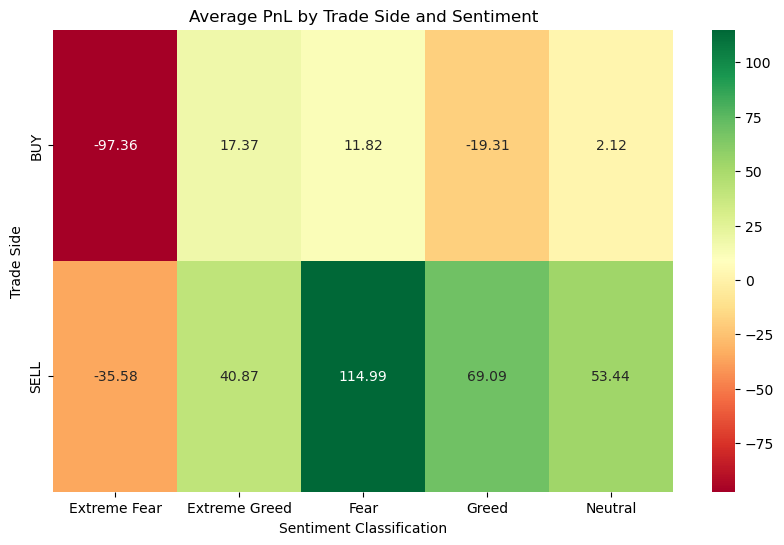

Saved plot: plots/top_traders_win_rate.png


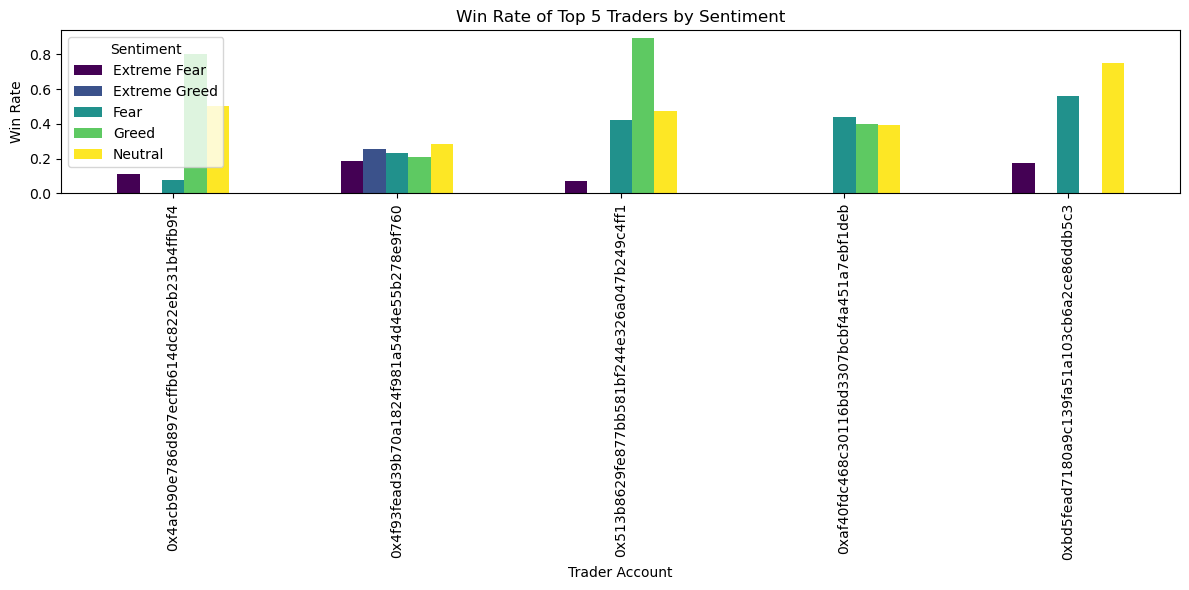

Saved plot: plots/profitability_vs_sentiment.png


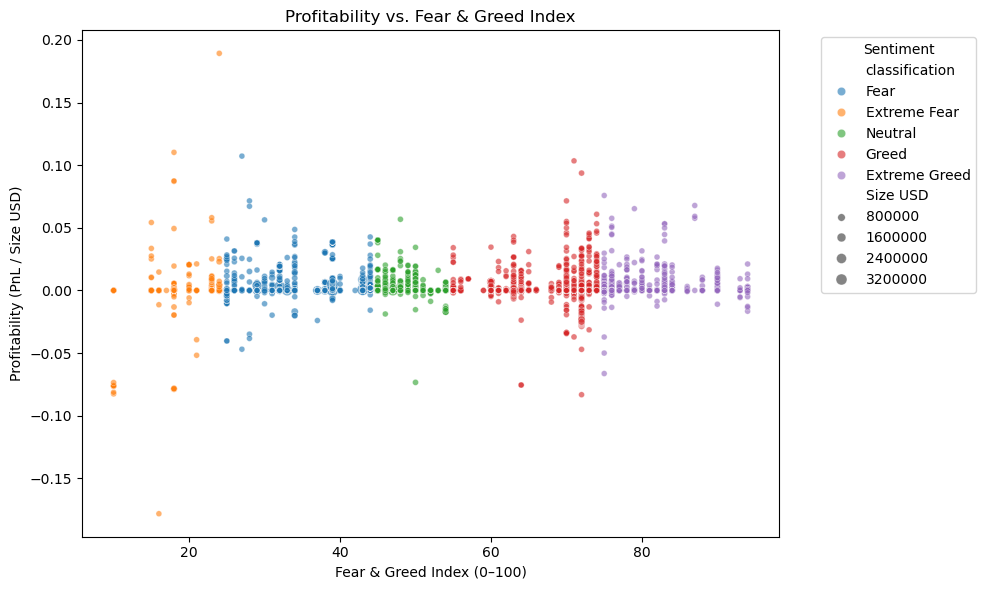

Saved plot: plots/win_rate_by_sentiment.png


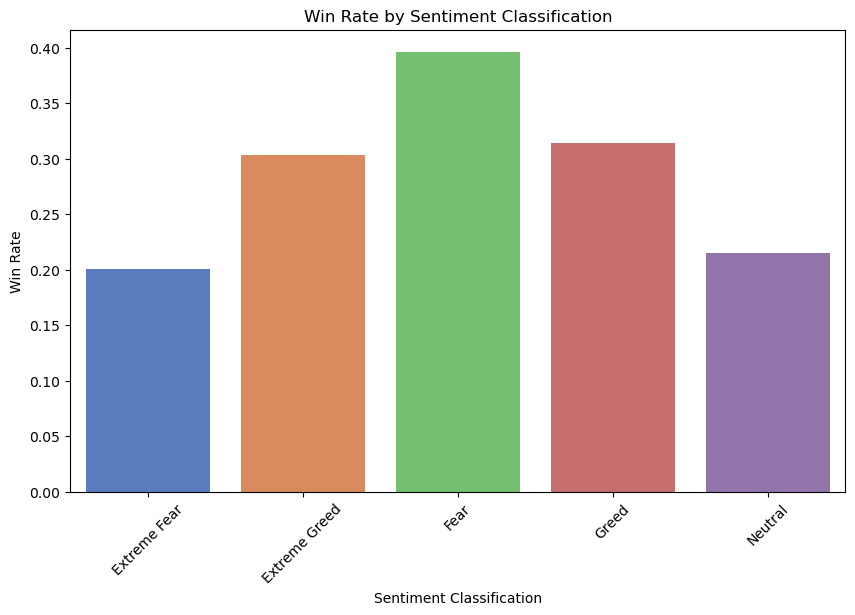

Saved plot: plots/trade_size_by_sentiment.png


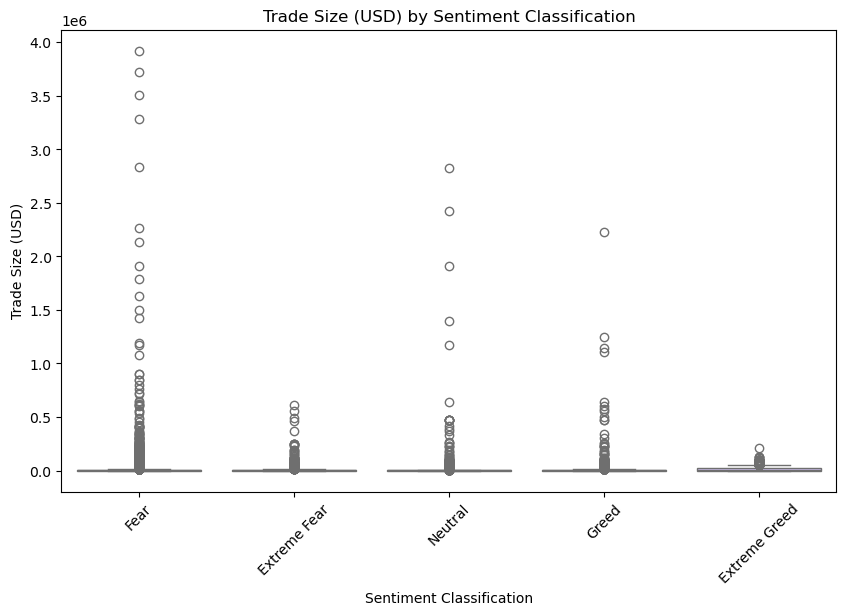


Correlation between Sentiment and Profitability: -0.059 (p-value: 0.000)

Regression Coefficients:
value: -0.334
Size USD: 0.002
is_extreme_fear: -117.371
is_extreme_greed: 7.865
Intercept: 17.530

Mean Profitability in Extreme Fear (value < 25): -0.001
Mean Profitability in Extreme Greed (value > 75): 0.003

Insights and Recommendations:
Win rate in Extreme Fear: 0.200, Extreme Greed: 0.304
Mean PnL for Buy in Extreme Fear: nan
Mean PnL for Sell in Extreme Greed: nan

Trading Strategy Recommendations:
- Buy during Extreme Fear (value < 25) for higher win rates.
- Reduce trade size during Extreme Greed to manage risk.
- Monitor 7-day sentiment average for trend confirmation.


In [15]:
# Main function
def main():
    sentiment_path = r"C:\Users\ACER\Downloads\fear_greed_index.csv"
    trader_path = r"C:\Users\ACER\Downloads\historical_data.csv"
    
    sentiment_df, trader_df = load_data(sentiment_path, trader_path)
    if sentiment_df is None or trader_df is None:
        return
    
    merged_df = preprocess_data(sentiment_df, trader_df)
    if merged_df is None:
        return
    
    perform_eda(merged_df)
    statistical_analysis(merged_df)
    derive_insights(merged_df)

if __name__ == "__main__":
    main()